# Image Classification and Verification using CNNs on the CompCars Dataset

## Car Make Classification

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2

# Libraries for PyTorch
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### Load Dataset

In [2]:
# Specify the path to training directory
train_dir = 'dataset_classification/dataset_classification/train_images'

# List all files in the directory
files = os.listdir(train_dir)

# Filter out only image files
image_extensions = {'.png', '.jpg', '.jpeg', '.bmp', '.gif'}
images = [f for f in files if os.path.splitext(f)[1].lower() in image_extensions]

# Count the number of images
num_images_train = len(images)

print(f'Number of images in the training set: {num_images_train}')

Number of images in the training set: 4289


In [3]:
# Specify the path to testing directory
test_dir = 'dataset_classification/dataset_classification/test_images'

# List all files in the directory
files = os.listdir(test_dir)

# Filter out only image files
image_extensions = {'.png', '.jpg', '.jpeg', '.bmp', '.gif'}
images = [f for f in files if os.path.splitext(f)[1].lower() in image_extensions]

# Count the number of images
num_images_test = len(images)

print(f'Number of images in the testing set: {num_images_test}')

Number of images in the testing set: 4043


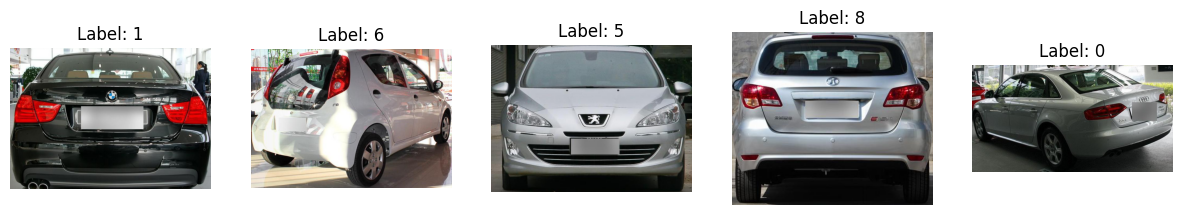

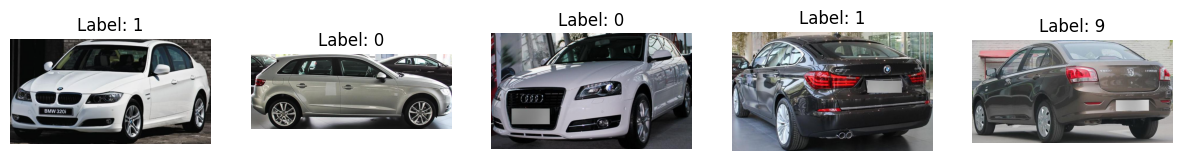

In [4]:
# Plot some examples of the dataset
# Define paths for labels
train_labels_file = 'dataset_classification/dataset_classification/train_labels1.csv'
test_labels_file = 'dataset_classification/dataset_classification/test_labels1.csv'

# Function to plot examples
def plot_examples(output_dir, labels_file, num_examples=5):
    # Read labels
    df = pd.read_csv(labels_file)

    # Plot images with labels
    fig, axs = plt.subplots(1, num_examples, figsize=(15, 5))

    for i, (index, row) in enumerate(df.sample(num_examples).iterrows()):
        image_path = os.path.join(output_dir, row['image'])
        label = row['label']

        # Ensure the path is a file and not a directory
        if os.path.isfile(image_path):
            # Open image
            img = Image.open(image_path)

            # Plot image
            axs[i].imshow(img)
            axs[i].set_title(f'Label: {label}')
            axs[i].axis('off')
        else:
            axs[i].text(0.5, 0.5, 'Skipped', ha='center', va='center', fontsize=12, color='red')
            axs[i].axis('off')

    plt.show()

# Plot examples from training set
plot_examples(train_dir, train_labels_file, num_examples=5)

# Plot examples from testing set
plot_examples(test_dir, test_labels_file, num_examples=5)


In [5]:
# Define the path to the image
image_path = 'dataset_classification/dataset_classification/train_images/0a0434d473138b.jpg'

# check the size of the image input
img = cv2.imread(image_path)
height, width, channels = img.shape
print(f'Image Size: {width}x{height}, Channels: {channels}')

Image Size: 514x420, Channels: 3


In [6]:
#### Prepare the dataset format for training in PyTorch ####

# Set the seed for reproducibility
seed = 123
torch.manual_seed(seed)

# set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
# Read the CSV Files
train_label = pd.read_csv('dataset_classification/dataset_classification/train_labels1.csv')
test_label = pd.read_csv('dataset_classification/dataset_classification/test_labels1.csv')

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)), # resize because inputs have different dimensions
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the test dataset
train_dataset = CustomDataset(dataframe=train_label, image_dir=train_dir, transform=transform)
test_set = CustomDataset(dataframe=test_label, image_dir=test_dir, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])


# Create data loaders
train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=32, shuffle=True)


### ResNet

In [14]:
# Define the BasicBlock

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = F.relu(out)

        return out

In [15]:
# Define the ResNet Architecture

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [16]:
# Instantiate the ResNet Model
def resnet18(num_classes=1000):
    return ResNet(ResidualBlock, [2, 2, 2, 2], num_classes)

In [8]:
# Training Function

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=25):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        corrects = torch.tensor(0, dtype=torch.float32, device=device)

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = corrects / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy.item())
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}')
        
        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        val_corrects = torch.tensor(0, dtype=torch.float32, device=device)  # Initialize as float32

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)

                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                val_running_loss += val_loss.item() * val_inputs.size(0)
                _, val_preds = torch.max(val_outputs, 1)
                val_corrects += torch.sum(val_preds == val_labels.data)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_accuracy = val_corrects / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy.item())
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


    return train_losses, train_accuracies, val_losses, val_accuracies



In [9]:
# Evaluation Function
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    corrects = torch.tensor(0, dtype=torch.float32, device=device)  # Initialize as float32

    class_totals = [0] * 10  # Initialize a list for total counts of each class
    class_hits = [0] * 10  # Initialize a list for hit counts of each class

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)

            for label, pred in zip(labels, preds):
                class_totals[label] += 1
                if label == pred:
                    class_hits[label] += 1

            batch_loss = loss.item()
            batch_accuracy = torch.sum(preds == labels.data) / inputs.size(0)

    return batch_loss, batch_accuracy, class_totals, class_hits


In [17]:
# Define the model
num_classes = len(train_label['label'].unique())
print('Number of classes:', num_classes)
model_res = resnet18(num_classes=num_classes)

# Move the model to the GPU
model_res = model_res.to(device)

Number of classes: 10


In [15]:
# Loss function and optimizer
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model_res.parameters(), lr=0.001)
num_epochs = 25

In [16]:
# Train the model and save loss values
train_losses1, train_accuracies1, val_losses1, val_accuracies1 = train_model(model_res, train_loader, val_loader, criterion1, optimizer1, device, num_epochs)

Epoch 1/25, Training Loss: 2.1147, Training Accuracy: 0.2478
Epoch 1/25, Validation Loss: 2.1495, Validation Accuracy: 0.2067
Epoch 2/25, Training Loss: 1.9466, Training Accuracy: 0.2861
Epoch 2/25, Validation Loss: 2.3068, Validation Accuracy: 0.2432
Epoch 3/25, Training Loss: 1.8780, Training Accuracy: 0.3165
Epoch 3/25, Validation Loss: 2.2317, Validation Accuracy: 0.2906
Epoch 4/25, Training Loss: 1.7765, Training Accuracy: 0.3734
Epoch 4/25, Validation Loss: 2.2939, Validation Accuracy: 0.2836
Epoch 5/25, Training Loss: 1.6399, Training Accuracy: 0.4214
Epoch 5/25, Validation Loss: 2.0905, Validation Accuracy: 0.2914
Epoch 6/25, Training Loss: 1.5333, Training Accuracy: 0.4624
Epoch 6/25, Validation Loss: 2.0228, Validation Accuracy: 0.3147
Epoch 7/25, Training Loss: 1.3697, Training Accuracy: 0.5350
Epoch 7/25, Validation Loss: 2.0456, Validation Accuracy: 0.3854
Epoch 8/25, Training Loss: 1.1758, Training Accuracy: 0.5969
Epoch 8/25, Validation Loss: 1.5853, Validation Accuracy:

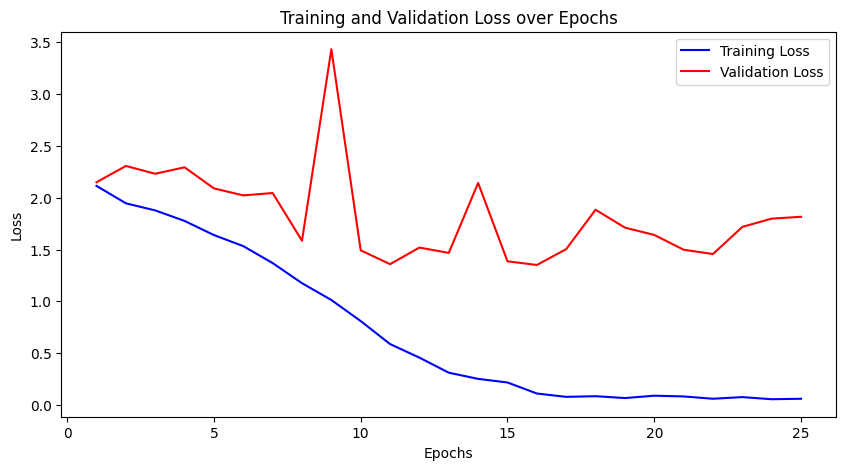

In [17]:
# Plot for training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses1, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses1, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

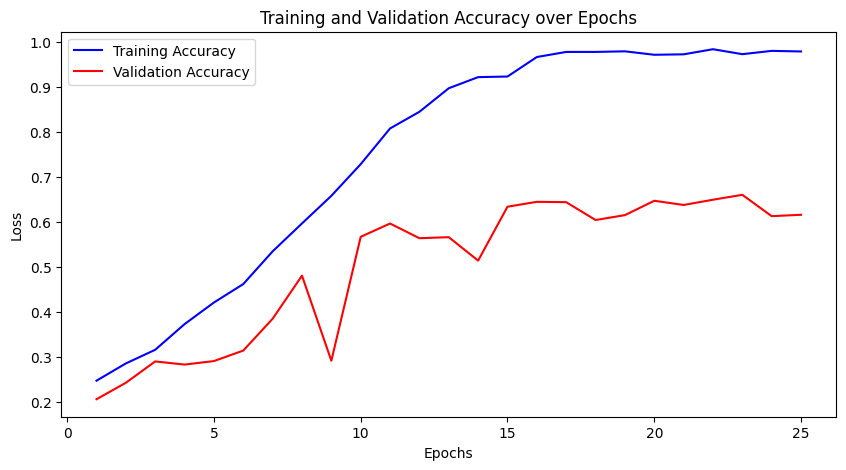

In [18]:
# Plot for training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies1, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies1, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()

In [19]:
# Evaluate the performace by testing set
test_loss1, test_accuracy1, class_totals1, class_hits1 = evaluate_model(model_res,test_loader, criterion1, device)

In [20]:
print(f'The Test Loss is: {test_loss1:.4f}')
print(f'The Test Accuracy is: {test_accuracy1.item():.4f}')

The Test Loss is: 1.5318
The Test Accuracy is: 0.6364


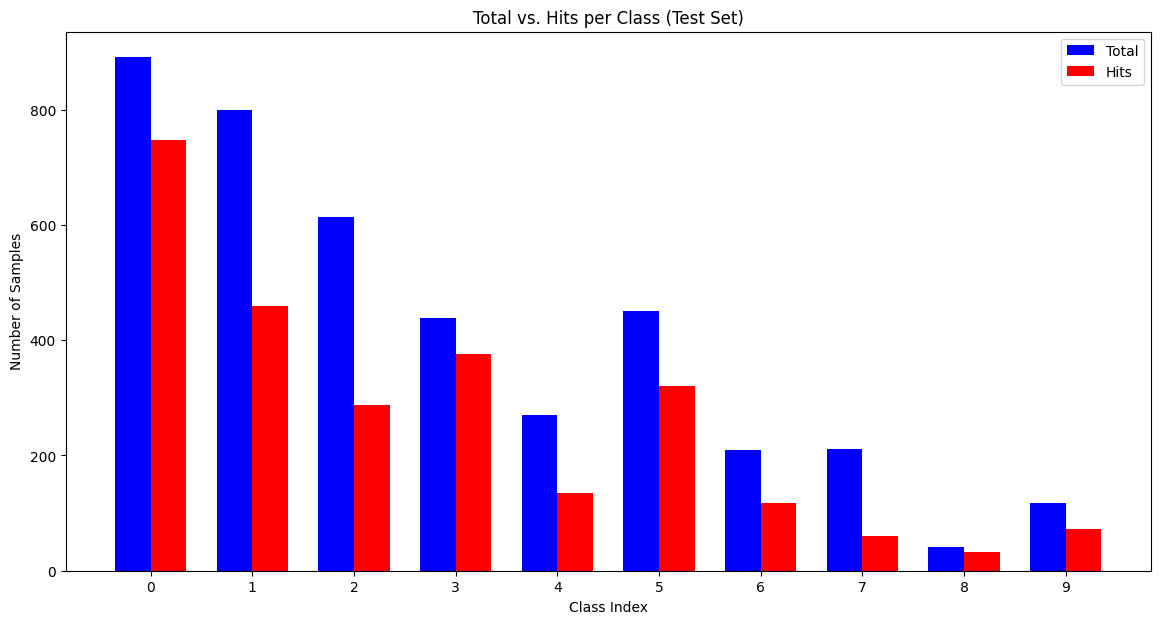

In [21]:
# Histogram for classes hits
def plot_histogram(class_totals, class_hits):
    indices = np.arange(len(class_totals))
    width = 0.35

    fig, ax = plt.subplots(figsize=(14, 7))

    bars1 = ax.bar(indices - width / 2, class_totals, width, label='Total', color='blue')
    bars2 = ax.bar(indices + width / 2, class_hits, width, label='Hits', color='red')

    ax.set_xlabel('Class Index')
    ax.set_ylabel('Number of Samples')
    ax.set_title('Total vs. Hits per Class (Test Set)')
    ax.set_xticks(indices)
    ax.set_xticklabels(indices)
    ax.legend()

    plt.show()

plot_histogram(class_totals1, class_hits1)

#### Focal Loss

In [22]:
#### Classification tasks with imbalanced datasets. Focuses on hard-to-classify examples.
# Focal Loss define
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss


In [23]:
# Define the model
model_res2 = resnet18(num_classes=num_classes)

# Move the model to the GPU
model_res2 = model_res2.to(device)

# Initialize the Focal Loss function
criterion2 = FocalLoss(alpha=1, gamma=2, reduction='mean')
optimizer2 = optim.Adam(model_res2.parameters(), lr=0.001)
num_epochs = 25

In [24]:
# Train the model and save loss values
train_losses2, train_accuracies2, val_losses2, val_accuracies2 = train_model(model_res2, train_loader, val_loader, criterion2, optimizer2, device, num_epochs)

Epoch 1/25, Training Loss: 1.6610, Training Accuracy: 0.2199
Epoch 1/25, Validation Loss: 1.6608, Validation Accuracy: 0.2222
Epoch 2/25, Training Loss: 1.4760, Training Accuracy: 0.2678
Epoch 2/25, Validation Loss: 1.5912, Validation Accuracy: 0.2315
Epoch 3/25, Training Loss: 1.3982, Training Accuracy: 0.3071
Epoch 3/25, Validation Loss: 1.7183, Validation Accuracy: 0.2603
Epoch 4/25, Training Loss: 1.2863, Training Accuracy: 0.3538
Epoch 4/25, Validation Loss: 1.5687, Validation Accuracy: 0.2704
Epoch 5/25, Training Loss: 1.1635, Training Accuracy: 0.4104
Epoch 5/25, Validation Loss: 1.5728, Validation Accuracy: 0.3256
Epoch 6/25, Training Loss: 1.0238, Training Accuracy: 0.4597
Epoch 6/25, Validation Loss: 1.1611, Validation Accuracy: 0.4071
Epoch 7/25, Training Loss: 0.8601, Training Accuracy: 0.5443
Epoch 7/25, Validation Loss: 2.3002, Validation Accuracy: 0.3318
Epoch 8/25, Training Loss: 0.7144, Training Accuracy: 0.5963
Epoch 8/25, Validation Loss: 1.5607, Validation Accuracy:

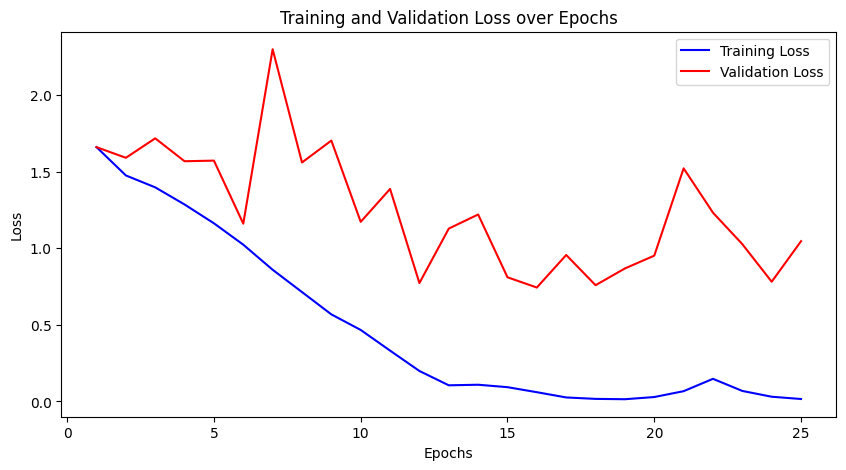

In [25]:
# Plot for training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses2, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses2, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

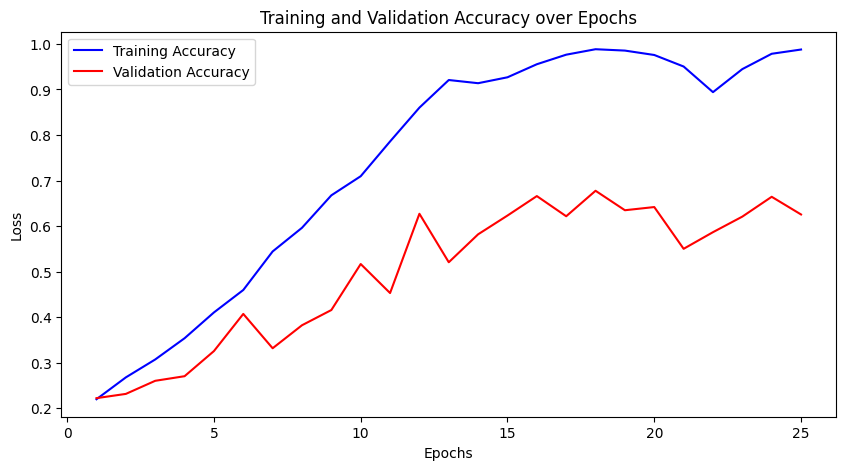

In [26]:
# Plot for training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies2, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies2, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()

In [27]:
# Test loss and accuracy
test_loss2, test_accuracy2, class_totals2, class_hits2 = evaluate_model(model_res2, test_loader, criterion2, device)
print(f'The Test Loss is: {test_loss2:.4f}')
print(f'The Test Accuracy is: {test_accuracy2.item():.4f}')

The Test Loss is: 1.5273
The Test Accuracy is: 0.6364


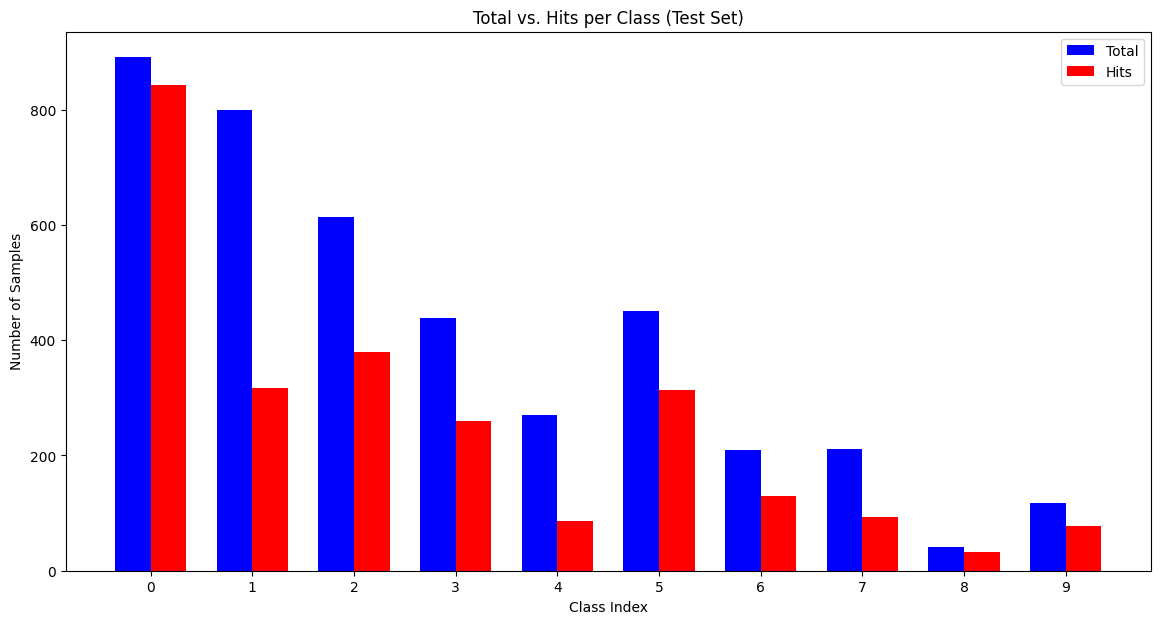

In [28]:
plot_histogram(class_totals2, class_hits2)

##### Fine Tuning Hyperparameters of Focal Loss

In [29]:
# Define the model
model_res3 = resnet18(num_classes=num_classes)

# Move the model to the GPU
model_res3 = model_res3.to(device)

# Initialize the Focal Loss function
criterion3 = FocalLoss(alpha=0.25, gamma=2, reduction='mean')
optimizer3 = optim.Adam(model_res3.parameters(), lr=0.001)
num_epochs = 25

In [30]:
# Train the model and save loss values
train_losses3, train_accuracies3, val_losses3, val_accuracies3 = train_model(model_res3, train_loader, val_loader, criterion3, optimizer3, device, num_epochs)

Epoch 1/25, Training Loss: 0.4121, Training Accuracy: 0.2278
Epoch 1/25, Validation Loss: 0.4066, Validation Accuracy: 0.2020
Epoch 2/25, Training Loss: 0.3800, Training Accuracy: 0.2618
Epoch 2/25, Validation Loss: 0.3971, Validation Accuracy: 0.2657
Epoch 3/25, Training Loss: 0.3663, Training Accuracy: 0.2775
Epoch 3/25, Validation Loss: 0.4579, Validation Accuracy: 0.2813
Epoch 4/25, Training Loss: 0.3540, Training Accuracy: 0.2781
Epoch 4/25, Validation Loss: 0.3510, Validation Accuracy: 0.3116
Epoch 5/25, Training Loss: 0.3361, Training Accuracy: 0.3341
Epoch 5/25, Validation Loss: 0.3748, Validation Accuracy: 0.2976
Epoch 6/25, Training Loss: 0.3089, Training Accuracy: 0.3701
Epoch 6/25, Validation Loss: 0.3190, Validation Accuracy: 0.3846
Epoch 7/25, Training Loss: 0.2833, Training Accuracy: 0.4197
Epoch 7/25, Validation Loss: 0.3136, Validation Accuracy: 0.3893
Epoch 8/25, Training Loss: 0.2568, Training Accuracy: 0.4707
Epoch 8/25, Validation Loss: 0.3031, Validation Accuracy:

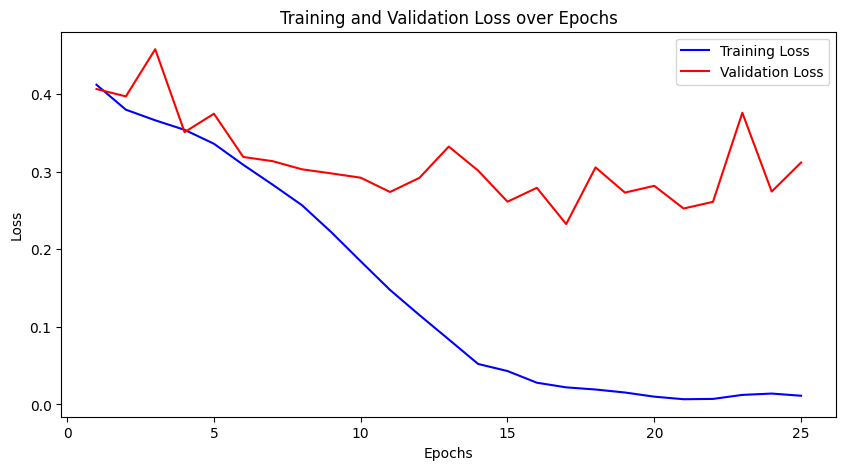

In [31]:
# Plot for training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses3, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses3, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

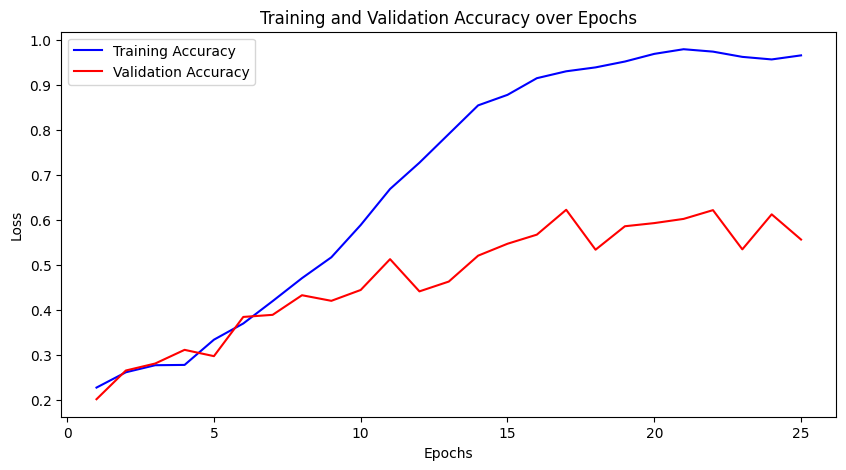

In [32]:
# Plot for training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies3, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies3, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()

In [33]:
# Test loss and accuracy
test_loss3, test_accuracy3, class_totals3, class_hits3 = evaluate_model(model_res3, test_loader, criterion3, device)
print(f'The Test Loss is: {test_loss3:.4f}')
print(f'The Test Accuracy is: {test_accuracy3.item():.4f}')

The Test Loss is: 0.1659
The Test Accuracy is: 0.6364


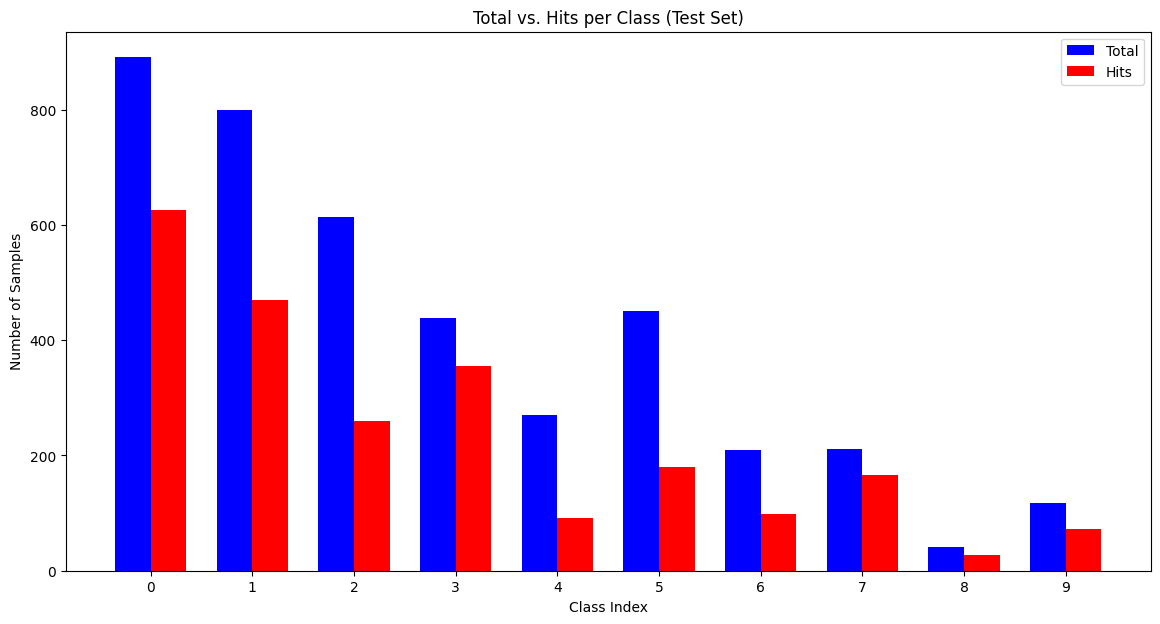

In [34]:
plot_histogram(class_totals3, class_hits3)

### Compare Performaces of Different Models

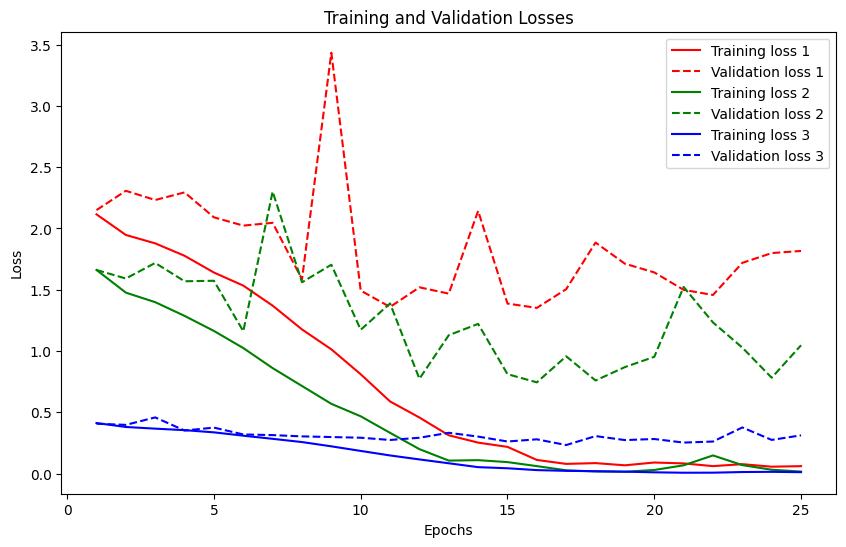

In [35]:
plt.figure(figsize=(10, 6))

# Plot for first set of losses
plt.plot(range(1, num_epochs + 1), train_losses1, 'r', label='Training loss 1')
plt.plot(range(1, num_epochs + 1), val_losses1, 'r--', label='Validation loss 1')

# Plot for second set of losses
plt.plot(range(1, num_epochs + 1), train_losses2, 'g', label='Training loss 2')
plt.plot(range(1, num_epochs + 1), val_losses2, 'g--', label='Validation loss 2')

# Plot for third set of losses
plt.plot(range(1, num_epochs + 1), train_losses3, 'b', label='Training loss 3')
plt.plot(range(1, num_epochs + 1), val_losses3, 'b--', label='Validation loss 3')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

plt.show()

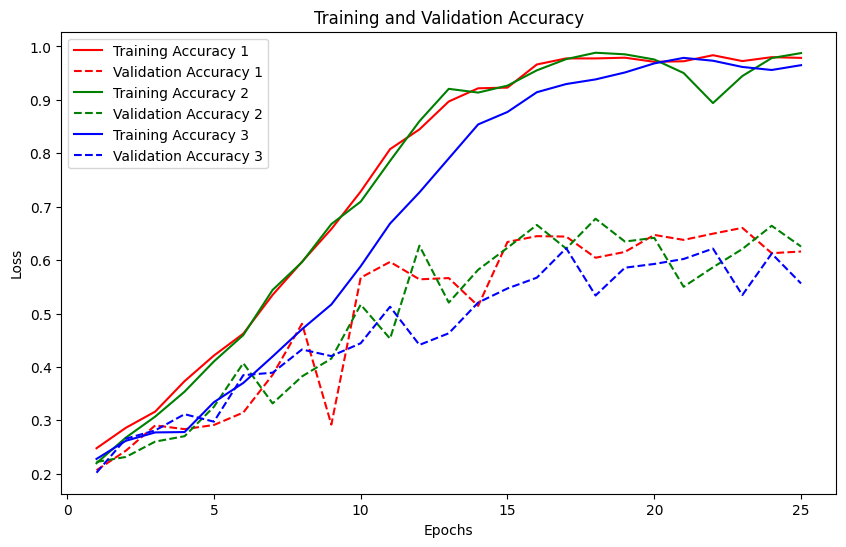

In [36]:
plt.figure(figsize=(10, 6))

# Plot for first set of losses
plt.plot(range(1, num_epochs + 1), train_accuracies1, 'r', label='Training Accuracy 1')
plt.plot(range(1, num_epochs + 1), val_accuracies1, 'r--', label='Validation Accuracy 1')

# Plot for second set of losses
plt.plot(range(1, num_epochs + 1), train_accuracies2, 'g', label='Training Accuracy 2')
plt.plot(range(1, num_epochs + 1), val_accuracies2, 'g--', label='Validation Accuracy 2')

# Plot for third set of losses
plt.plot(range(1, num_epochs + 1), train_accuracies3, 'b', label='Training Accuracy 3')
plt.plot(range(1, num_epochs + 1), val_accuracies3, 'b--', label='Validation Accuracy 3')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

## GoogLeNet

In [10]:
# architecture for Inception (GoogLeNet)

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_1x1, reduce_3x3, out_3x3, reduce_5x5, out_5x5, out_pool):
        super(InceptionModule, self).__init__()
        self.branch1 = nn.Conv2d(in_channels, out_1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, reduce_3x3, kernel_size=1),
            nn.Conv2d(reduce_3x3, out_3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, reduce_5x5, kernel_size=1),
            nn.Conv2d(reduce_5x5, out_5x5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)

class GoogLeNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(3, stride=2, ceil_mode=True),
            nn.LocalResponseNorm(64),
            nn.Conv2d(64, 64, kernel_size=1),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.LocalResponseNorm(192),
            nn.MaxPool2d(3, stride=2, ceil_mode=True)
        )

        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)
        
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x
    


#### Cross-Entropy Loss

In [12]:
# Instantiate the model
model_gn1 = GoogLeNet(num_classes=10)

# Move the model to the GPU
model_gn1 = model_gn1.to(device)

# Loss function and optimizer
criterion4 = nn.CrossEntropyLoss()
optimizer4 = torch.optim.Adam(model_gn1.parameters(), lr=0.001)
num_epochs = 25

In [14]:
# Train the model and save loss values
train_losses4, train_accuracies4, val_losses4, val_accuracies4 = train_model(model_gn1, train_loader, val_loader, criterion4, optimizer4, device, num_epochs)

Epoch 1/25, Training Loss: 6.7966, Training Accuracy: 0.1616
Epoch 1/25, Validation Loss: 2.1717, Validation Accuracy: 0.1943
Epoch 2/25, Training Loss: 2.1018, Training Accuracy: 0.2059
Epoch 2/25, Validation Loss: 2.0627, Validation Accuracy: 0.2191
Epoch 3/25, Training Loss: 2.0653, Training Accuracy: 0.2225
Epoch 3/25, Validation Loss: 2.0566, Validation Accuracy: 0.1997
Epoch 4/25, Training Loss: 2.0530, Training Accuracy: 0.2278
Epoch 4/25, Validation Loss: 2.0387, Validation Accuracy: 0.2261
Epoch 5/25, Training Loss: 2.0444, Training Accuracy: 0.2308
Epoch 5/25, Validation Loss: 2.0545, Validation Accuracy: 0.2331
Epoch 6/25, Training Loss: 2.0287, Training Accuracy: 0.2352
Epoch 6/25, Validation Loss: 2.0053, Validation Accuracy: 0.2665
Epoch 7/25, Training Loss: 2.0420, Training Accuracy: 0.2412
Epoch 7/25, Validation Loss: 2.0689, Validation Accuracy: 0.2315
Epoch 8/25, Training Loss: 2.0230, Training Accuracy: 0.2372
Epoch 8/25, Validation Loss: 2.0265, Validation Accuracy:

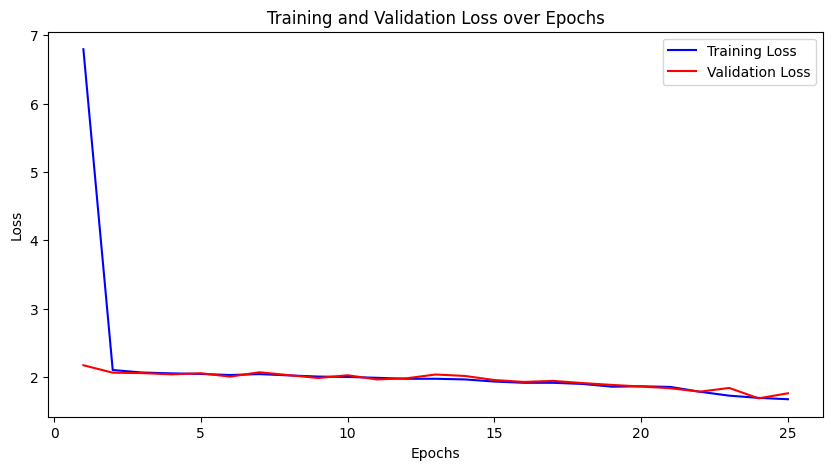

In [15]:
# Plot for training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses4, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses4, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

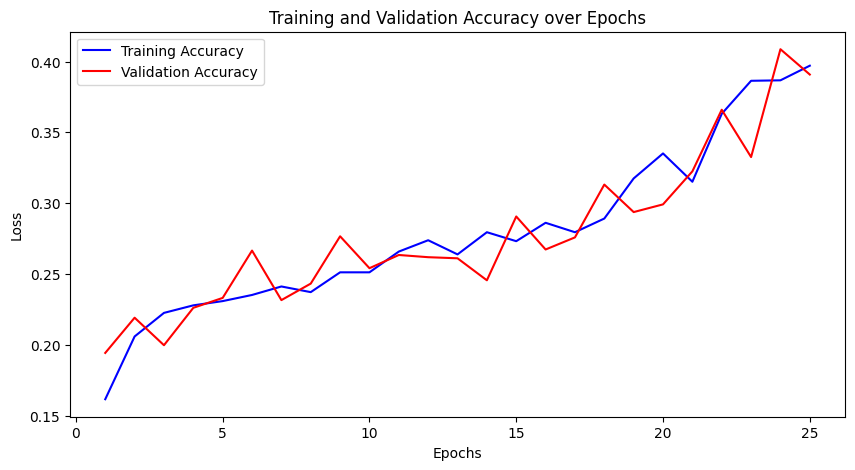

In [16]:
# Plot for training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies4, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies4, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()

In [ ]:
# Test loss and accuracy
test_losses4, test_accuracies4, class_totals4, class_hits4 = evaluate_model(model_gn1, test_loader, criterion4, device)


In [ ]:
print(f'The Test Loss is: {test_losses4:.4f}')
print(f'The Test Accuracy is: {test_accuracies4.item():.4f}')

In [ ]:
# Histogram for classes hits
def plot_histogram(class_totals, class_hits):
    indices = np.arange(len(class_totals))
    width = 0.35

    fig, ax = plt.subplots(figsize=(21, 7))

    bars1 = ax.bar(indices - width / 2, class_totals, width, label='Total', color='blue')
    bars2 = ax.bar(indices + width / 2, class_hits, width, label='Hits', color='red')

    ax.set_xlabel('Class Index')
    ax.set_ylabel('Number of Samples')
    ax.set_title('Total vs. Hits per Class (Test Set)')
    ax.set_xticks(indices)
    ax.set_xticklabels(indices)
    ax.legend()

    plt.show()

plot_histogram(class_totals4, class_hits4)

#### Focal Loss

In [ ]:
# Define the model
model_gn2 = GoogLeNet(num_classes=num_classes)

# Move the model to the GPU
model_gn2 = model_gn2.to(device)

# Initialize the Focal Loss function
criterion5 = FocalLoss(alpha=1, gamma=2, reduction='mean')
optimizer5 = optim.Adam(model_gn2.parameters(), lr=0.001)
num_epochs = 25

In [ ]:
# Train the model and save loss values
train_losses5, train_accuracies5, val_losses5, val_accuracies5 = train_model(model_gn2, train_loader, val_loader, criterion5, optimizer5, device, num_epochs)

In [ ]:
# Plot for training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses5, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses5, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [ ]:
# Plot for training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies5, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies5, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()

In [ ]:
# Test loss and accuracy
test_loss5, test_accuracy5, class_totals5, class_hits5 = evaluate_model(model_gn2, test_loader, criterion5, device)
print(f'The Test Loss is: {test_loss2:.4f}')
print(f'The Test Accuracy is: {test_accuracy2.item():.4f}')

In [ ]:
plot_histogram(class_totals5, class_hits5)

##### Fine Tuning Hyperparameters of Focal Loss

In [ ]:
# Define the model
model_gn3 = GoogLeNet(num_classes=num_classes)

# Move the model to the GPU
model_gn3 = model_gn.to(device)

# Initialize the Focal Loss function
criterion6 = FocalLoss(alpha=0.25, gamma=2, reduction='mean')
optimizer6 = optim.Adam(model_gn3.parameters(), lr=0.001)
num_epochs = 25

In [ ]:
# Train the model and save loss values
train_losses6, train_accuracies6, val_losses6, val_accuracies6 = train_model(model_gn3, train_loader, val_loader, criterion6, optimizer6, device, num_epochs)

In [ ]:
# Plot for training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses6, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses6, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [ ]:
# Plot for training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies6, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies6, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()

In [ ]:
# Test loss and accuracy
test_loss6, test_accuracy6, class_totals6, class_hits6 = evaluate_model(model_gn3, test_loader, criterion6, device)
print(f'The Test Loss is: {test_loss6:.4f}')
print(f'The Test Accuracy is: {test_accuracy6.item():.4f}')

In [ ]:
plot_histogram(class_totals6, class_hits6)

### Compare Performaces of Different Models

In [ ]:
plt.figure(figsize=(10, 6))

# Plot for first set of losses
plt.plot(range(1, num_epochs + 1), train_losses4, 'r', label='Training loss 4')
plt.plot(range(1, num_epochs + 1), val_losses4, 'r--', label='Validation loss 4')

# Plot for second set of losses
plt.plot(range(1, num_epochs + 1), train_losses5, 'g', label='Training loss 5')
plt.plot(range(1, num_epochs + 1), val_losses5, 'g--', label='Validation loss 5')

# Plot for third set of losses
plt.plot(range(1, num_epochs + 1), train_losses6, 'b', label='Training loss 6')
plt.plot(range(1, num_epochs + 1), val_losses6, 'b--', label='Validation loss 6')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

# Plot for first set of losses
plt.plot(range(1, num_epochs + 1), train_accuracies4, 'r', label='Training Accuracy 4')
plt.plot(range(1, num_epochs + 1), val_accuracies4, 'r--', label='Validation Accuracy 4')

# Plot for second set of losses
plt.plot(range(1, num_epochs + 1), train_accuracies5, 'g', label='Training Accuracy 5')
plt.plot(range(1, num_epochs + 1), val_accuracies5, 'g--', label='Validation Accuracy 5')

# Plot for third set of losses
plt.plot(range(1, num_epochs + 1), train_accuracies6, 'b', label='Training Accuracy 6')
plt.plot(range(1, num_epochs + 1), val_accuracies6, 'b--', label='Validation Accuracy 6')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()